# Assignment IHE Hydrology, Transient Groundwater 2024

Prof. dr.ir. T.N.Olsthoorn 
Feb 18, 2024


## Pumping experiment

1. The drawdown over time caused by the pumping over a long period for a set of piezometer (distances) from the well.

Show the drawdown development for the piezometers over time on logarithmic time scales since the start of the pumping test.
Try to simulate them with both Theis and Hantush. You can first analyse the drawdown development using methods on half-log paper or double log paper. Then simulate the measurements to the extent possible.
Then explain the results.

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.special import exp1
from scipy.integrate import quad
from itertools import cycle
import hemkmaas87 as hm87
from Students2024 import students

In [32]:
IHE24 = '/Users/Theo/Entiteiten/IHE/IHE2023-2024/'
ASSIGN = os.path.join(IHE24, 'Assignment')
DATA = os.path.join(ASSIGN, 'data')
IMAG = os.path.join(ASSIGN, 'images')

for d in [IHE24, ASSIGN, DATA, IMAG]:
    assert os.path.isdir(d), 'Directory <{}> not found!'.format(d)

In [33]:
def find_primes(n):
    """Return all prime numbers from 2 through n (Sieve of Eratosthenes)."""    
    primes = set(np.arange(2, n))
    for i in range(2, n):        
        primes = primes.difference(np.arange(2 * i, n, i))        
    return np.array(sorted(primes))

find_primes(175)

array([  2,   3,   5,   7,  11,  13,  17,  19,  23,  29,  31,  37,  41,
        43,  47,  53,  59,  61,  67,  71,  73,  79,  83,  89,  97, 101,
       103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167,
       173])

In [34]:
def rf():
    """Return a random number from N(1, 0.1)"""
    return np.random.normal(1, 0.1)


In [35]:
def newfig(title='title', xlabel='xlabel', ylabel='ylabel', xscale='linear', yscale='linear',
           xlim=None, ylim=None, figsize=(6, 6)):
    """Return ax of new figure."""
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if figsize: fig.set_size_inches(figsize)
    ax.grid(True)
    return ax

In [36]:
def Wh(u, rho):
    """Return Hantush well function values.
    
    >>>Wh(0.004, 0.03)
    4.894104204671381
    >>>Wh(0.08, 0.06)
    2.0184074022446836
    """
    def kernel(y, rho):
        return np.exp(-y - (rho / 2) ** 2 / y) / y
    def w(u, rho):
        return quad(kernel, u, np.inf, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1)
    return wh(u, rho)

def W(u):
    """Return Theis well function values."""
    return exp1(u)

# Pumping experiment

In [37]:
# Generate data for the piezometeres
Q = 789 # m3/d
kD = 650 # m2/d
Sy = 0.2
S  = 0.002
c = 450 # d
c = 200

# Piezometer well distances:
R = [10, 20, 30, 50, 80, 125]

distances = np.zeros((len(students), len(R)))
for i in range(len(students)):
    distances[i] = [np.round(rf() * r_) for r_ in R]
print(distances)

[[ 12.  20.  32.  57.  70.  88.]
 [  9.  19.  36.  52.  75. 136.]
 [ 10.  19.  31.  43.  89. 127.]
 [  9.  17.  31.  57.  74. 130.]
 [ 11.  19.  33.  50.  90. 135.]
 [ 10.  19.  32.  53.  76. 124.]
 [  9.  19.  34.  52.  88. 121.]]


## Hantush (and Theis) type curves

The type curves show the well function, of Hantush or Theis, as a function of 1/u on double log scales. The reason to use $1/u$ instead of $u$ is because is is proportional to time, so that the well fuction, like the drawdown, that it compputes increase with time. The reason to plot on double log scales is because the shape type curves then stay the same as that of the actual drawdown, whatever the extractioin and the parameters are.

The type curves of both Hantush and Theis are shown below. The outer line, thicker black line, is the Theis type curve, which is the same as the Hantush type curve for an infnite vertical resistance of the overlying aquitard, so that all extarcted water has to come from storage and from storage only.

It's also clear form the figure, that only Hantush drawdowns will reach some steady-state equilibrium drawdown, while the Theis curve never does.

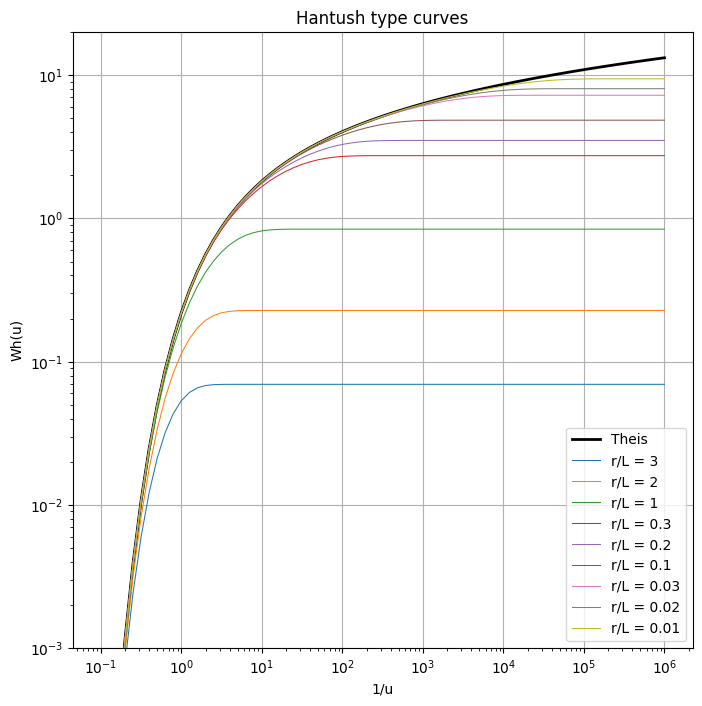

In [38]:
ax = newfig('Hantush type curves', '1/u', 'Wh(u)', xscale='log', yscale='log',
            ylim=(1e-3, 20), figsize=(8, 8))

u = np.logspace(-6, 1, 71)

# The Theis type curve
ax.plot(1 / u, W(u), 'k', lw=2, label='Theis')

# Hantush type curves for different values of rho=r/L
for rho in [3, 2, 1, 0.3, 0.2, 0.1, 0.03, 0.02, 0.01]:
    plt.plot(1 / u, Wh(u, rho), lw=0.75, label='r/L = {:.3g}'.format(rho))
ax.legend(loc='lower right')

### It's up to you to show the head in at the used idstances and flows by superposition, where the changes in head are split up in a few larger steps.

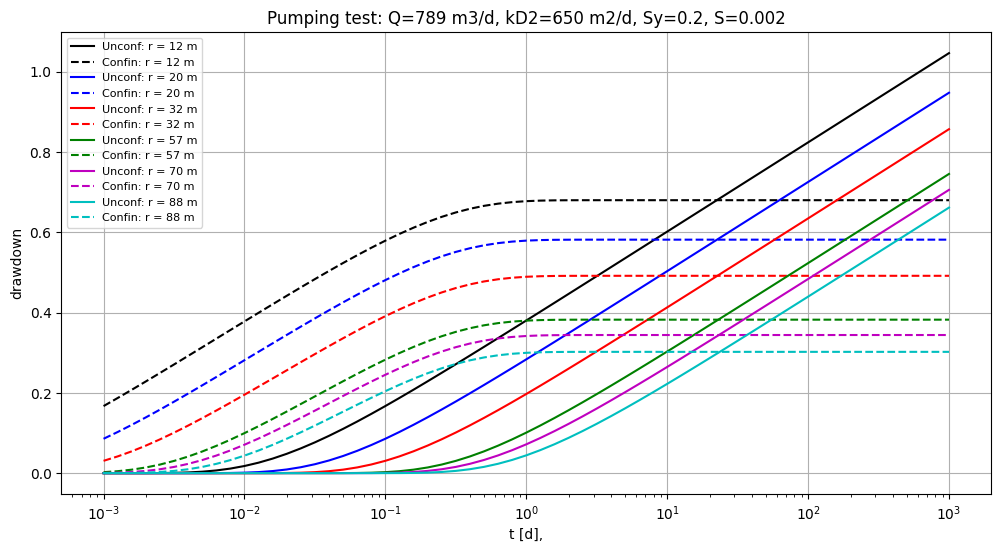

In [39]:
ax = newfig("Pumping test: Q={:.0f} m3/d, kD2={:.0f} m2/d, Sy={:.3g}, S={:.3g}".format(Q, kD, Sy, S),
            "t [d],", "drawdown", xscale='log', yscale='linear', figsize=(12, 6))

L = np.sqrt(kD * c)
t = np.logspace(-3, 3, 61)
clrs = cycle('kbrgmc')
for r in distances[0]:
    clr = next(clrs)
    uy = r ** 2 * Sy  / (4 * kD * t)
    u  = r ** 2 * S  / (4 * kD * t)
    rho = r / L
    
    # Theis
    sy = Q / (4 * np.pi * kD) * exp1(uy) 
    
    # Hantush
    s  = Q / (4 * np.pi * kD) * Wh(u, r / L)
    
    ax.plot(t, sy,      color=clr, label='Unconf: r = {:.0f} m'.format(r))
    ax.plot(t, s, '--', color=clr, label='Confin: r = {:.0f} m'.format(r))
    
ax.legend(loc='upper left',  fontsize=8)

In [40]:
case = dict()
case['Hant2'] = {
        'name': 'Hantush using 2 layers', # Hantush using two layers with low intermediate resistance
        'Q' : np.array([0, Q]),
        'kD': np.array([1e-2, kD]),
        'S' : np.array([Sy, S]),
        'c' : np.array([1e+7, c, 1e+7]),
        'St': np.array([0e-0, 0e-0, 0e-0]),
        'topclosed': True,
        'botclosed': True,
        'label': 'Hantush',
        }

for student in students:
    st_name = student[-1]
    case[st_name] = case['Hant2'].copy()
    case[st_name][ 'Q'][-1] = np.round(789 * rf())
    case[st_name]['kD'][-1] = np.round(650 * rf())
    case[st_name][ 'c'][ 0] = np.round(100 * rf())

case

{'Hant2': {'name': 'Hantush using 2 layers',
  'Q': array([  0, 746]),
  'kD': array([1.00e-02, 7.21e+02]),
  'S': array([0.2  , 0.002]),
  'c': array([9.3e+01, 2.0e+02, 1.0e+07]),
  'St': array([0., 0., 0.]),
  'topclosed': True,
  'botclosed': True,
  'label': 'Hantush'},
 'Theo_Olsthoorn': {'name': 'Hantush using 2 layers',
  'Q': array([  0, 746]),
  'kD': array([1.00e-02, 7.21e+02]),
  'S': array([0.2  , 0.002]),
  'c': array([9.3e+01, 2.0e+02, 1.0e+07]),
  'St': array([0., 0., 0.]),
  'topclosed': True,
  'botclosed': True,
  'label': 'Hantush'},
 'Lima_Niao': {'name': 'Hantush using 2 layers',
  'Q': array([  0, 746]),
  'kD': array([1.00e-02, 7.21e+02]),
  'S': array([0.2  , 0.002]),
  'c': array([9.3e+01, 2.0e+02, 1.0e+07]),
  'St': array([0., 0., 0.]),
  'topclosed': True,
  'botclosed': True,
  'label': 'Hantush'},
 'Joshua_Trotman': {'name': 'Hantush using 2 layers',
  'Q': array([  0, 746]),
  'kD': array([1.00e-02, 7.21e+02]),
  'S': array([0.2  , 0.002]),
  'c': array([9

# Generate drawdown values for analysis by the students

In [51]:
#df.to_csv(fname)
fname

'/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/data/Isaq_Tuna/pump_test/piez121m.csv'

['tolsthoorn@gmail.com', 'Theo_Olsthoorn']


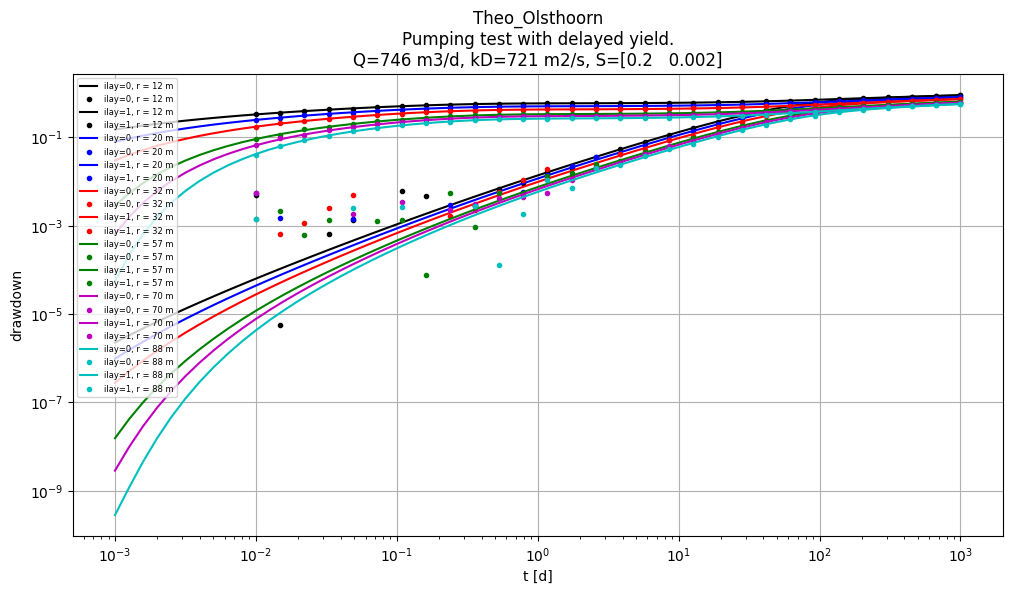

['lnj001@un-ihe.org', 'Lima_Niao']


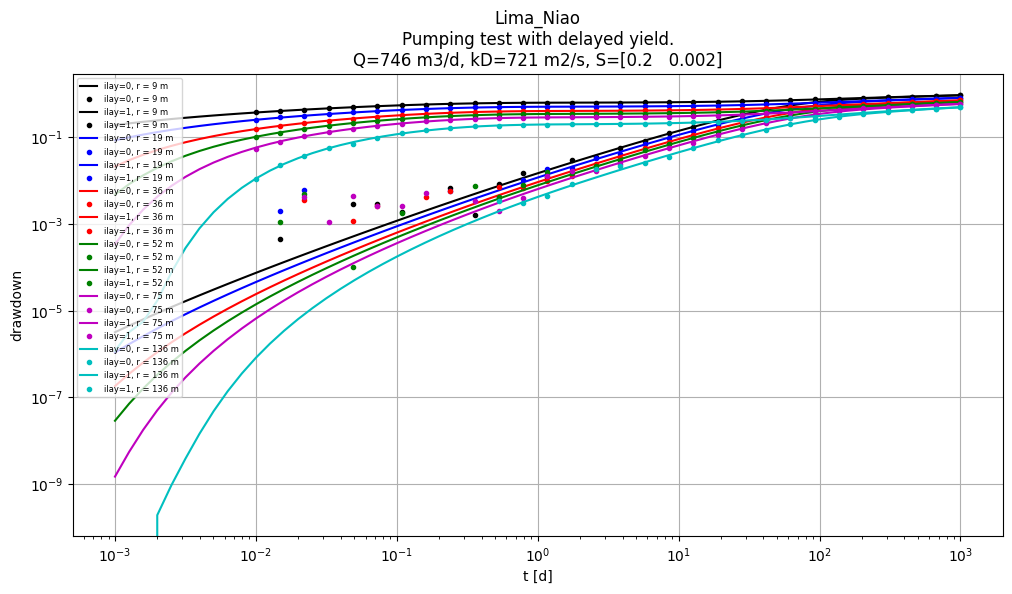

['jtr002@un-ihe.org', 'Joshua_Trotman']


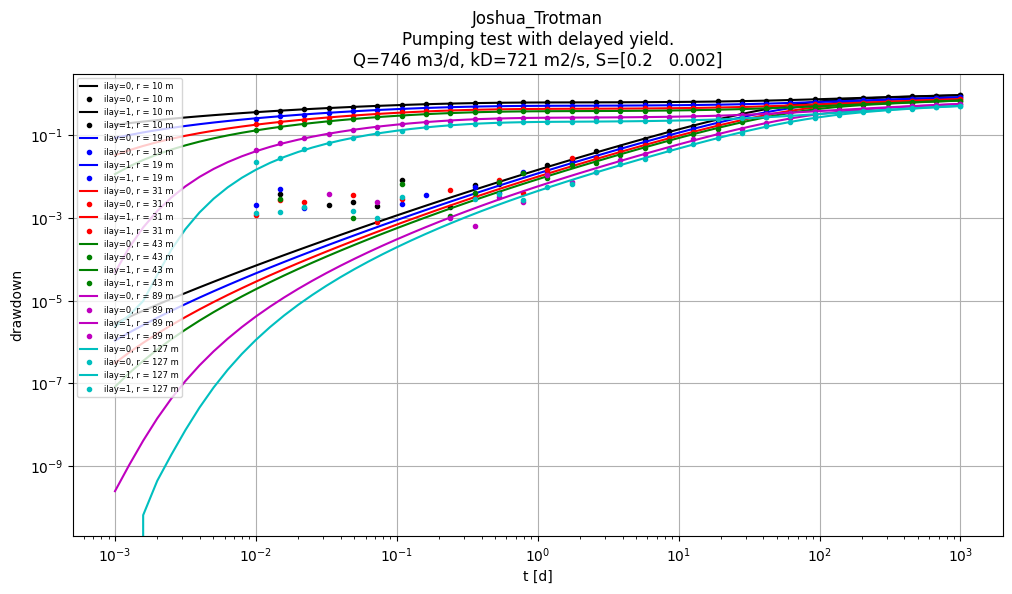

['ynd001@un-ihe.org', 'Joshua_Ndolele']


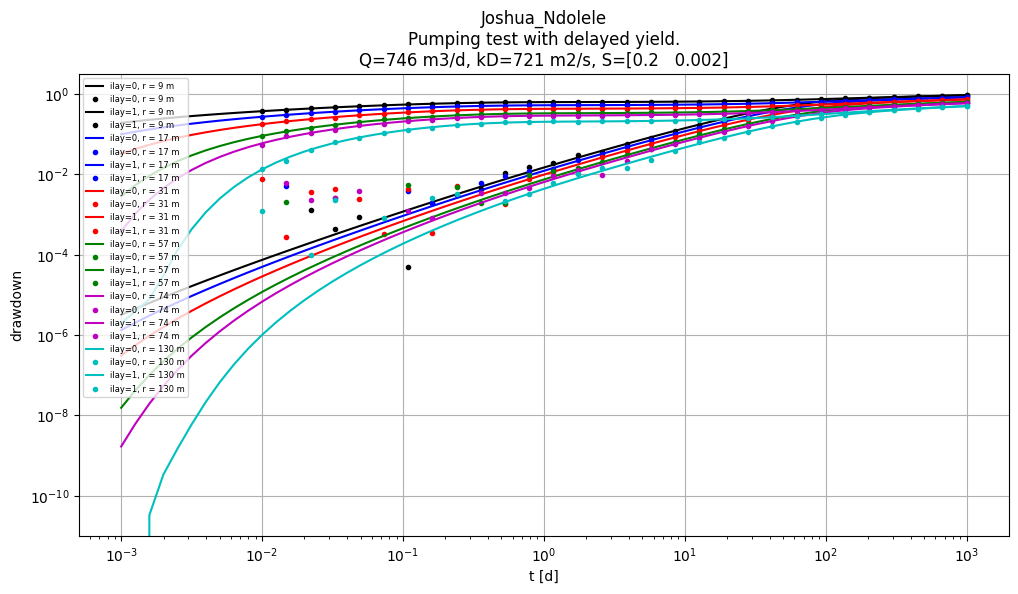

['tka004@un-ihe.org', 'Tamandani_Kamuyanja']


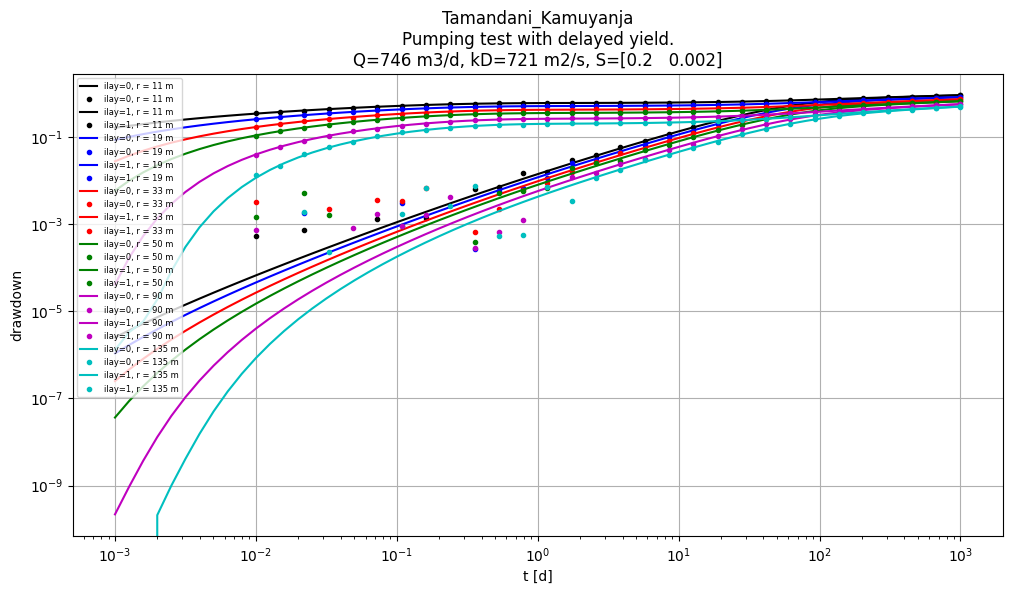

['vur002@un-ihe.org', 'Valentina_Urrea_Vargas']


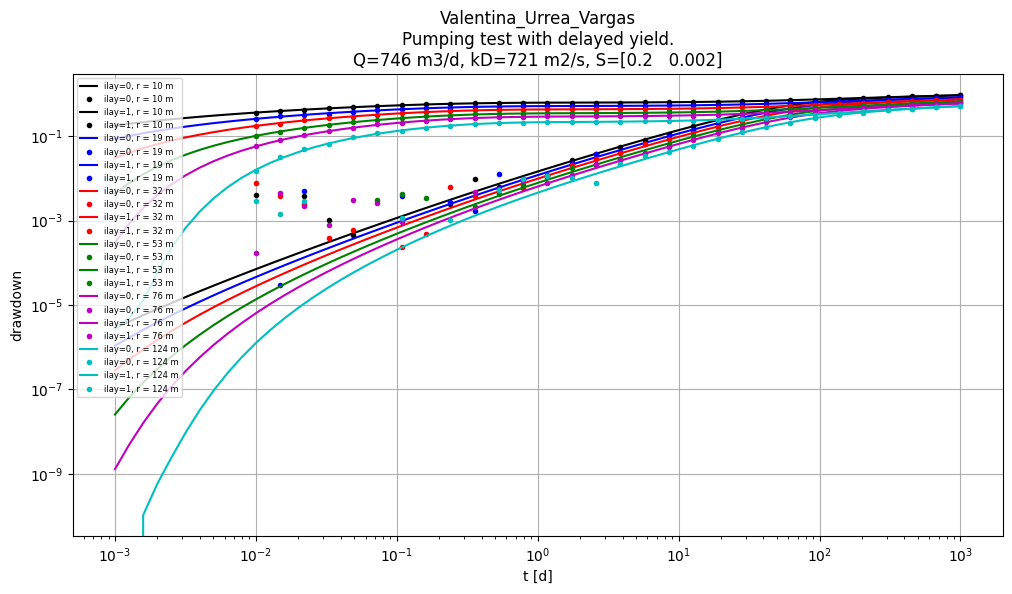

['itu002@un-ihe.org', 'Isaq_Tuna']


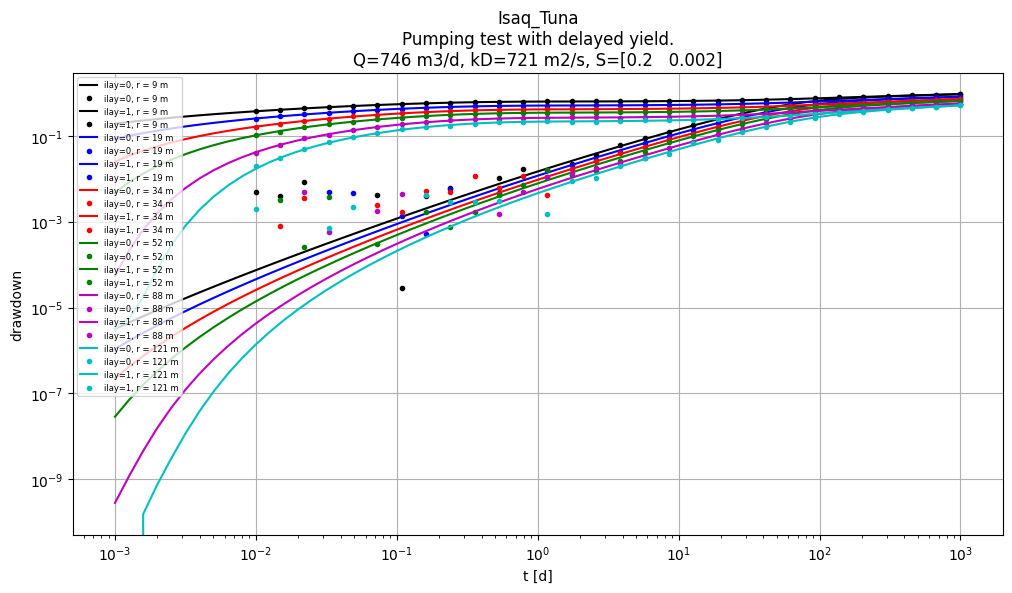

In [44]:
for student, rs in zip(students, distances):
    print(student)
    st_name = student[-1]
    st_dir = os.path.join(DATA, st_name)
    ws_dir = os.path.join(st_dir, 'pump_test')
    if not os.path.isdir(st_dir):
        os.mkdir(st_dir)
    if not os.path.isdir(ws_dir):
        os.mkdir(ws_dir)

    ax = newfig("{}\nPumping test with delayed yield.\nQ={:.0f} m3/d, kD={:.0f} m2/s, S={}".format(
        st_name, case[st_name]['Q'][1], case[st_name]['kD'][1], case[st_name]['S']),
                "t [d]", "drawdown", xscale='log', yscale='log', figsize=(12, 6))

    clrs = cycle('kbrgmc')
    lns  = cycle(['-', '--'])
    sample_times = np.array([float('{:.3g}'.format(t_)) for t_ in np.logspace(-2, 3, 30)])
    
    for r in rs:
            
        drawdowns    = hm87.solution(ts=t,            rs=r, **case['Hant2'])
        measurements = hm87.solution(ts=sample_times, rs=r, **case['Hant2'])

        noise = np.random.normal(loc=0.0, scale=0.003, size=measurements.shape)

        measurements += noise
            
        clr = next(clrs)
        for il, (s, s_meas) in enumerate(zip(drawdowns, measurements)):
            ls = next(lns)        
            ax.plot(t, s,                 '-', color=clr, label='ilay={}, r = {:.0f} m'.format(il, r))
            ax.plot(sample_times, s_meas, '.', color=clr, label='ilay={}, r = {:.0f} m'.format(il, r))

        df = pd.DataFrame(index=pd.Index(sample_times, name='time_d'),
                            data={'aquif1': measurements[0], 'aquif2': measurements[1]})                                
        fname = os.path.join(ws_dir, 'piez{:.0f}m.csv'.format(r))
        df.round(3).to_csv(fname)
    
    ax.legend(loc='upper left', fontsize=6)
    plt.show()
    

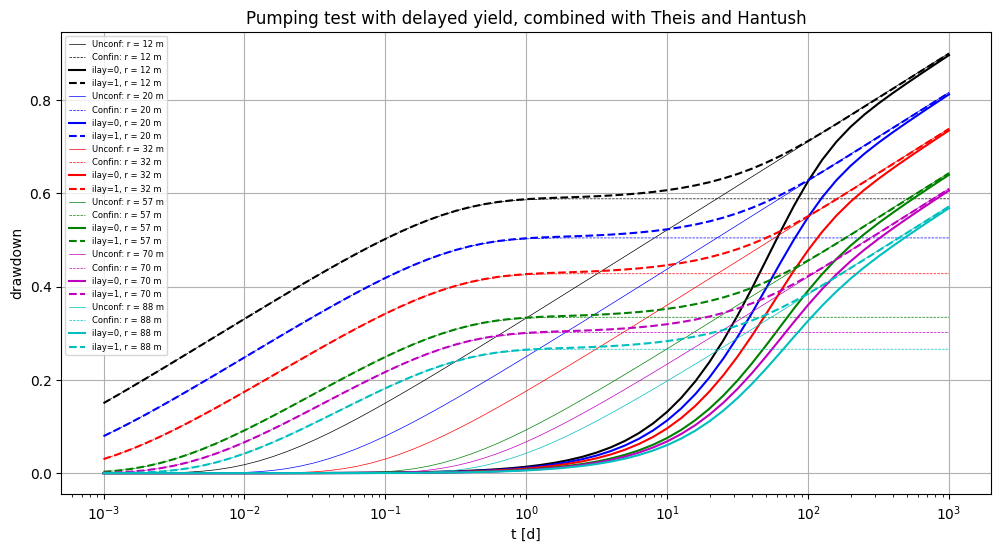

In [43]:
ax = newfig("Pumping test with delayed yield, combined with Theis and Hantush", "t [d]", "drawdown",
            xscale='log', yscale='linear', figsize=(12, 6))

clrs = cycle('kbrgmc')
lns  = cycle(['-', '--'])

Q  = case['Hant2']['Q'][1]
kD = case['Hant2']['kD'][1]
Sy = case['Hant2']['S'][0]
S  = case['Hant2']['S'][1]
c  = case['Hant2']['c'][1]
L = np.sqrt(kD * c)

for r in distances[0]:
    clr = next(clrs)
    uy = r ** 2 * Sy  / (4 * kD * t)
    u  = r ** 2 * S   / (4 * kD * t)
    rho = r / L
    
    # Theis
    sy = Q / (4 * np.pi * kD) * exp1(uy) 
    
    # Hantush
    s  = Q / (4 * np.pi * kD) * Wh(u, r / L)

    ls = next(lns)
    ax.plot(t, sy, color=clr, ls=ls, lw=0.5, label='Unconf: r = {:.0f} m'.format(r))
    ls = next(lns)
    ax.plot(t, s,  color=clr, ls=ls, lw=0.5, label='Confin: r = {:.0f} m'.format(r))

    drawdowns = hm87.solution(ts=t, rs=r, **case['Hant2'])
    for il, s in enumerate(drawdowns):
        ls = next(lns)        
        ax.plot(t, s,  color=clr, ls=ls, label='ilay={}, r = {:.0f} m'.format(il, r))

ax.legend(loc='upper left', fontsize=6)

